In [ ]:
!git clone https://github.com/abzargar/COVID-Classifier

Cloning into 'COVID-Classifier'...
remote: Enumerating objects: 1002, done.
remote: Total 1002 (delta 0), reused 0 (delta 0), pack-reused 1002
Receiving objects: 100% (1002/1002), 128.89 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
import os
import sys
import cv2
import time
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
img_dir = '/content/COVID-Classifier/dataset/original_images'

In [ ]:
os.listdir (img_dir)

['normal', 'pneumonia']

In [ ]:
img = cv2.imread (os.path.join ('/content/COVID-Classifier/dataset/original_images/pneumonia/person10_bacteria_43.jpeg'))
img1 = cv2.imread (os.path.join ('/content/COVID-Classifier/dataset/original_images_preprocessed/pneumonia/person10_bacteria_43.jpeg'))
print (img.shape)
print (img1.shape)

(650, 1028, 3)
(512, 512, 3)


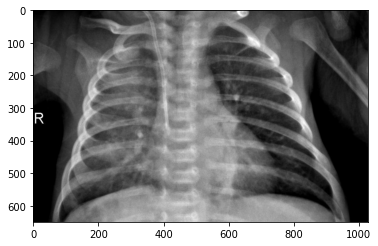

In [ ]:
plt.imshow (img)

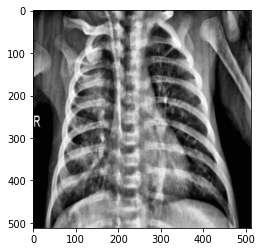

In [ ]:
plt.imshow (img1)

In [ ]:
for fname in os.listdir (img_dir):
    print (len (os.listdir (os.path.join (img_dir, fname))))

100
141


In [ ]:
import shutil
src = '/content/COVID-Classifier/dataset/original_images/covid'
dst = '/content/covid'
shutil.move (src, dst)

In [ ]:
tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize (mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
    ])

In [ ]:
dataset = ImageFolder (img_dir, transform = tfms)

In [ ]:
dataset.classes

['normal', 'pneumonia']

In [ ]:
dataset.class_to_idx

{'normal': 0, 'pneumonia': 1}

In [ ]:
dataloader = DataLoader(dataset, batch_size = 16, shuffle = False)

In [ ]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def accuracy (outputs, labels):
    """ calculate percent of true labels """
    # predicted labels
    _, preds = torch.max (outputs, dim = 1)
    return torch.sum (preds == labels).item () / len (preds)

In [ ]:
def evaluate (model, loader, loss_fn, metric_fn):
    """ Evaluate trained weights using calculate loss and metrics """
    # Evaluate model
    model.eval ()
    losses = 0.0
    metrics = 0.0

    with torch.no_grad ():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model (inputs)
            loss = loss_fn (outputs, labels)
            losses += loss

            metrics += metric_fn (outputs, labels)

    return losses.item () / len (loader), metrics / len (loader)

In [ ]:
def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])

In [ ]:
model = models.densenet201 (pretrained = False)

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 2)
)
model.to(device)

loss_fn = nn.CrossEntropyLoss ()
loss_fn.to(device)
checkpoint_path = '/content/drive/MyDrive/Datasets/DenseNet201(1).pth'

In [ ]:
model

In [ ]:
load_checkpoint (torch.load (checkpoint_path, map_location = device), model)

=> loading checkpoint


## Accuracy

In [ ]:
evaluate (model, dataloader, loss_fn, accuracy)

(1.2300212860107422, 0.575)

## Confusion Matrix

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


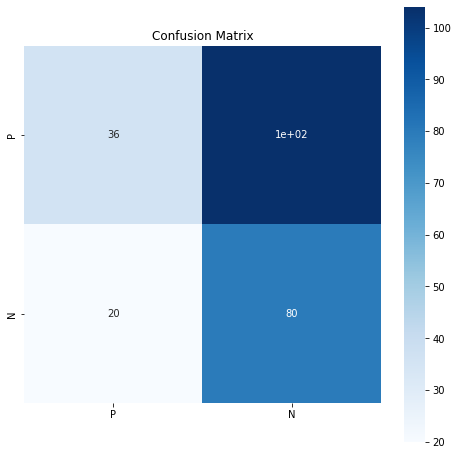

In [ ]:
y_test = []
y_pred = []

for imgs, lbls in dataloader:
    imgs = imgs.to(device)
    outputs = model (imgs)
    _, preds = torch.max (outputs, dim = 1)
    y_test += lbls.tolist ()
    y_pred += preds.tolist ()

plt.figure (figsize = (8, 8))
cm = confusion_matrix (y_test, y_pred)
cm = cm.ravel ()[::-1].reshape (2, 2)
cm_df = pd.DataFrame (cm, index = ['P', 'N'], columns = ['P', 'N'])
plt.title ('Confusion Matrix')
sns.heatmap (cm_df, annot = True, cmap = 'Blues', square = True)

## GradCam

In [ ]:
pip install pytorch-gradcam

     |████████████████████████████████| 6.0 MB 2.2 MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=e8ef8395c88092982784bf807eac21dcc4f2b54f029e4b881cb4ccaf3a7bdf16
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
def Tensor2array (img):
    return img.cpu ().numpy ().transpose (1, 2, 0)

In [ ]:
target_layer = model.features
gradcam = GradCAM (model, target_layer)
gradcam_pp = GradCAMpp (model, target_layer)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255

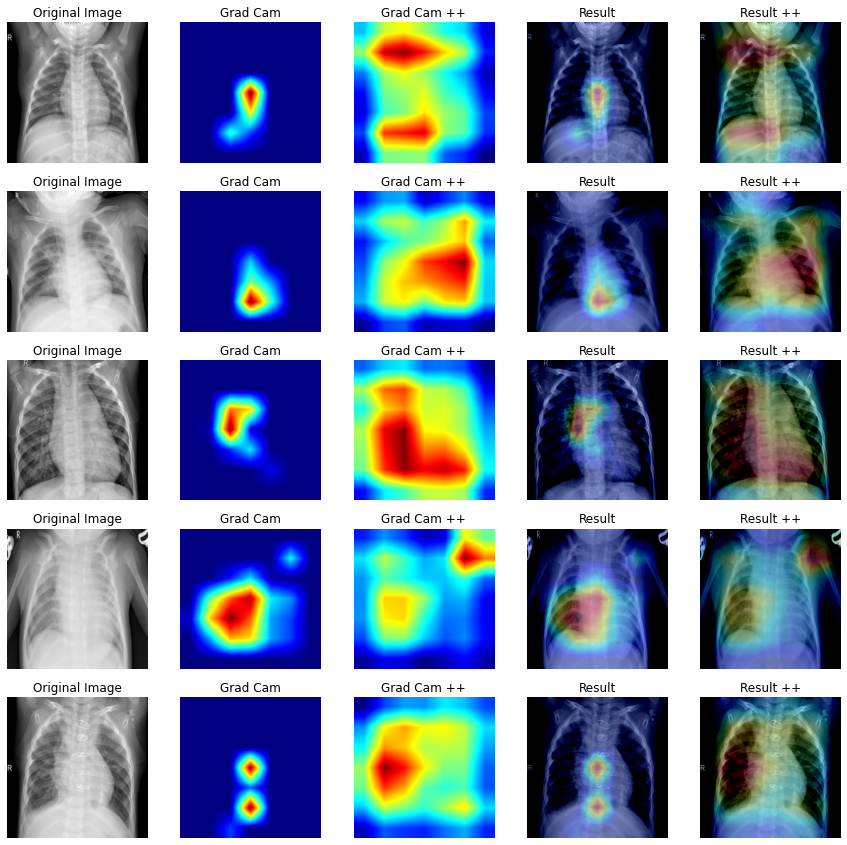

In [ ]:
plt.figure (figsize = (15, 15))
idxs = np.random.permutation (len (dataset)) [:5]
for i, idx in enumerate (idxs):
    img = dataset [idx][0]
    normed_img = transforms.Normalize (0.5, 0.5)(img)[None]

    mask, _ = gradcam (normed_img)
    heatmap, result = visualize_cam (mask, img)

    mask_pp, _ = gradcam_pp (normed_img)
    heatmap_pp, result_pp = visualize_cam (mask_pp, img)

    plt.subplot (5, 5, i*5 + 1)
    plt.imshow (img [0], cmap = 'gray')
    plt.title ('Original Image')
    plt.axis ('off')

    plt.subplot (5, 5, i * 5 + 2)
    plt.imshow (Tensor2array (heatmap))
    plt.title ('Grad Cam')
    plt.axis ('off')

    plt.subplot (5, 5, i * 5 + 3)
    plt.imshow (Tensor2array (heatmap_pp))
    plt.title ('Grad Cam ++')
    plt.axis ('off')

    plt.subplot (5, 5, i * 5 + 4)
    plt.imshow (Tensor2array (result))
    plt.title ('Result')
    plt.axis ('off')

    plt.subplot (5, 5, i * 5 + 5)
    plt.imshow (Tensor2array (result_pp))
    plt.title ('Result ++')
    plt.axis ('off')